In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms


In [2]:
# Hyperparameters
batch_size = 64
epochs = 50
lr = 0.00005
latent_dim = 100

In [3]:
# Data loader
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate networks


Files already downloaded and verified


In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Output: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Output: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Output: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Output: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)


In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 256 x 8 x 8 
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            # Output:512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Flatten()
            # Output: 1
        )

    def forward(self, x):
        return self.model(x)



In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)
optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_D = optim.RMSprop(D.parameters(), lr=lr)



In [7]:
clamp_lower = -0.01
clamp_upper = 0.01
n_critic = 5

In [8]:
import os
import torchvision.utils as vutils
from pathlib import Path

In [11]:
output_dir = Path("Images/wganimages")
output_dir.mkdir(parents=True, exist_ok=True)
real_images_dir = output_dir / "real"
real_images_dir.mkdir(parents=True, exist_ok=True)
fake_images_dir = output_dir / "fake"
fake_images_dir.mkdir(parents=True, exist_ok=True)


In [10]:

#Training
best_images = []
best_scores = []


# Save the real and generated images for each epoch
for epoch in range(epochs):
    for i, (batch_data, _) in enumerate(train_loader):
        # ... (the rest of your training code)
        
        # Save real and generated images for the current epoch
        if i == 0:
            vutils.save_image(batch_data[:10].cpu(), real_images_dir / f"image{epoch}.png", nrow=10, normalize=True)
            vutils.save_image(fake_data[:10].cpu(), fake_images_dir / f"image{epoch}.png", nrow=10, normalize=True)
            
    # ... (the rest of your training code)

# Save the 10 best generated images
best_images_grid = vutils.make_grid([img.unsqueeze(0) for img in best_images], padding=2, normalize=True, nrow=10)
vutils.save_image(best_images_grid.cpu(), "Images/wganimage10.png")


NameError: name 'fake_data' is not defined

In [ ]:
#Training
best_images = []
best_scores = []

# Save the real and generated images for each epoch and update best_images
for epoch in range(epochs):
    for i, (batch_data, _) in enumerate(train_loader):
        real_data = batch_data.to(device)
        real_data_size = real_data.size(0)
        
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            #Real data
            real_data_prediction = D(real_data)
            real_data_loss = -torch.mean(real_data_prediction)
            
            #Fake data
            noise = torch.randn(real_data_size, latent_dim, 1, 1, device = device)
            fake_data = G(noise)
            fake_data_prediction = D(fake_data.detach())
            fake_data_loss = -torch.mean(fake_data_prediction)
            
            #Update Discriminator 
            dis_loss = real_data_loss - fake_data_loss
            dis_loss.backward()
            optimizer_D.step()
            
            # Clip discriminator weights
            for p in D.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
            
            # Train Generator
        optimizer_G.zero_grad()

            
        #Generate fake data
        noise = torch.randn(real_data_size, latent_dim, 1, 1, device = device)
        fake_data = G(noise)
        fake_data_prediction = D(fake_data)
        # Update generator
        gen_loss = -torch.mean(fake_data_prediction)
        gen_loss.backward()
        optimizer_G.step()
           

        # Generate fake data and save images
    with torch.no_grad():
        fixed_noise = torch.randn(10, latent_dim, 1, 1, device=device)
        generated_images = G(fixed_noise).detach().cpu()
        img_scores = D(generated_images.to(device)).detach().cpu().numpy()

            # Update the best images list
        for img, score in zip(generated_images, img_scores):
            if len(best_images) < 10:
                best_images.append(img)
                best_scores.append(score)
            else:
                min_index = best_scores.index(min(best_scores))
                if score > best_scores[min_index]:
                    best_images[min_index] = img
                    best_scores[min_index] = score

        # Save real and generated images for the current epoch
    if i == 0:
        vutils.save_image(batch_data[:10].cpu(), real_images_dir / f"image{epoch}.png", nrow=10, normalize=True)
        vutils.save_image(generated_images[:10].cpu(), fake_images_dir / f"image{epoch}.png", nrow=10, normalize=True)

    print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {dis_loss.item():.4f} | G_loss: {gen_loss.item():.4f}")

# Save the 10 best generated images
best_images_grid = vutils.make_grid([img.unsqueeze(0) for img in best_images], padding=2, normalize=True, nrow=10)
vutils.save_image(best_images_grid.cpu(), "Images/wganimage10.png")



In [ ]:
import math

# Compute the number of images per row
num_images = len(best_images)
image_size = best_images[0].shape[-2]  # assuming all images have the same size
padding = 2
nrow = int(math.sqrt(num_images))  # use a square grid
while (nrow + 1) * image_size + nrow * padding <= 800:  # increase number of rows as long as it fits in 800 pixels width
    nrow += 1

# Create the grid of images
best_images_grid = vutils.make_grid(best_images, padding=padding, normalize=True, nrow=nrow)
vutils.save_image(best_images_grid.cpu(), "Images/wganimage10.png")


In [12]:
#Training
best_images = []
best_scores = []

for epoch in range(epochs):
    for i, (batch_data, _) in enumerate(train_loader):
        real_data = batch_data.to(device)
        real_data_size = real_data.size(0)
        
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            
            #Real data
            real_data_prediction = D(real_data)
            real_data_loss = -torch.mean(real_data_prediction)
            
            #Fake data
            noise = torch.randn(real_data_size, latent_dim, 1, 1, device = device)
            fake_data = G(noise)
            fake_data_prediction = D(fake_data.detach())
            fake_data_loss = -torch.mean(fake_data_prediction)
            
            #Update Discriminator 
            dis_loss = real_data_loss - fake_data_loss
            dis_loss.backward()
            optimizer_D.step()
            
            # Clip discriminator weights
            for p in D.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
            
            # Train Generator
        optimizer_G.zero_grad()
            
        #Generate fake data
        noise = torch.randn(real_data_size, latent_dim, 1, 1, device = device)
        fake_data = G(noise)
        fake_data_prediction = D(fake_data)
        # Update generator
        gen_loss = -torch.mean(fake_data_prediction)
        gen_loss.backward()
        optimizer_G.step()
        

    print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {dis_loss.item():.4f} | G_loss: {gen_loss.item():.4f}")

    # Generate and save images after each epoch
    with torch.no_grad():
        fixed_noise = torch.randn(10, latent_dim, 1, 1, device=device)
        generated_images = G(fixed_noise).detach().cpu()

    img_scores = D(generated_images.to(device)).detach().cpu().numpy()

    # Update the best images list
    for img, score in zip(generated_images, img_scores):
        if len(best_images) < 10:
            best_images.append(img)
            best_scores.append(score)
        else:
            min_index = best_scores.index(min(best_scores))
            if score > best_scores[min_index]:
                best_images[min_index] = img
                best_scores[min_index] = score 






Epoch [1/50] | D_loss: -1.5897 | G_loss: 0.7948
Epoch [2/50] | D_loss: -1.5841 | G_loss: 0.7920
Epoch [3/50] | D_loss: -1.5915 | G_loss: 0.7951
Epoch [4/50] | D_loss: -1.5963 | G_loss: 0.7975
Epoch [5/50] | D_loss: -1.5936 | G_loss: 0.7967
Epoch [6/50] | D_loss: -1.5447 | G_loss: 0.7693
Epoch [7/50] | D_loss: -1.4541 | G_loss: 0.7351
Epoch [8/50] | D_loss: -1.4715 | G_loss: 0.7446
Epoch [9/50] | D_loss: -1.4789 | G_loss: 0.7242
Epoch [10/50] | D_loss: -1.2119 | G_loss: 0.7382
Epoch [11/50] | D_loss: -1.4630 | G_loss: 0.7347
Epoch [12/50] | D_loss: -1.3853 | G_loss: 0.6969
Epoch [13/50] | D_loss: -1.4617 | G_loss: 0.7410
Epoch [14/50] | D_loss: -1.4306 | G_loss: 0.7181
Epoch [15/50] | D_loss: -1.4102 | G_loss: 0.7126
Epoch [16/50] | D_loss: -0.9111 | G_loss: 0.6334
Epoch [17/50] | D_loss: -1.2699 | G_loss: 0.5157
Epoch [18/50] | D_loss: -1.3070 | G_loss: 0.6801
Epoch [19/50] | D_loss: -1.0386 | G_loss: 0.6753
Epoch [20/50] | D_loss: -1.2085 | G_loss: 0.5713
Epoch [21/50] | D_loss: -1.45

In [13]:

import torchvision.utils as vutils
import matplotlib.pyplot as plt


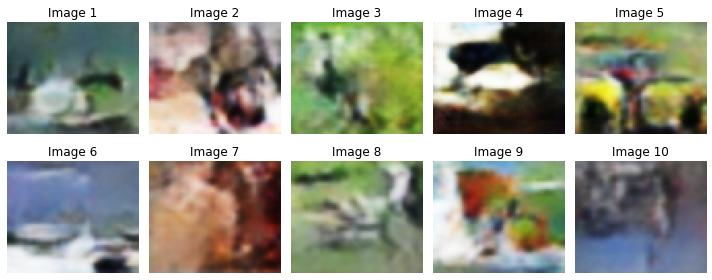

In [14]:
# Plot the 10 best generated images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, img in enumerate(best_images):
    ax = axes[i // 5, i % 5]
    img_np = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
    ax.imshow(img_np, aspect="auto")
    ax.set_title(f"Image {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:


import os
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Set the directories containing the real and generated images
real_images_dir = "/home/jingjiw/generated_images"
generated_images_dir = "/home/jingjiw/generated_images"

# Load the images as tensors
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

real_images_dataset = ImageFolder(real_images_dir, transform=transform)
generated_images_dataset = ImageFolder(generated_images_dir, transform=transform)

real_images_loader = DataLoader(real_images_dataset, batch_size=100, shuffle=False)
generated_images_loader = DataLoader(generated_images_dataset, batch_size=100, shuffle=False)

# Create a FrechetInceptionDistance instance
fid = FrechetInceptionDistance(feature=64)
# Update the FID instance with real and generated images
for real_images, _ in real_images_loader:
    real_images = real_images.to(torch.uint8)
    fid.update(real_images, real=True)

for generated_images, _ in generated_images_loader:
    generated_images = generated_images.to(torch.uint8)
    fid.update(generated_images, real=False)


# Compute the FID score
fid_score = fid.compute()
print(f"FID score: {fid_score}")


In [ ]:
import os
import numpy as np
from PIL import Image

os.makedirs("generated_images", exist_ok=True)

for i, img in enumerate(best_images):
    img_np = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    img_pil.save(f"generated_images/image_{i+1}.png")


In [ ]:
#from pytorch_fid.fid_score import fid_score

from pytorch_fid.fid_score import calculate_fid_given_paths

fid = calculate_fid_given_paths(["real_images", "generated_images"], 2048, device=device)
print(f"FID score: {fid:.4f}")

